# Cognitive Neuroscience Exam 
## Preprocessign of EEG data


In [1]:
!pip install mne[data]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 197.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.7 MB/s eta 0:00:0000:0100:01


In [2]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [3]:
raw = mne.io.read_raw_brainvision('/work/Cog_neuro_exam/own_group9.vhdr', eog= ('VEOG', 'HEOG'))
raw.load_data()

Extracting parameters from /work/Cog_neuro_exam/own_group9.vhdr...
Setting channel info structure...
Reading 0 ... 684819  =      0.000 ...   684.819 secs...


<RawBrainVision | own_group9.eeg, 32 x 684820 (684.8 s), ~167.2 MB, data loaded>

In [4]:
# specifying electrode location 
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose= False)

<RawBrainVision | own_group9.eeg, 32 x 684820 (684.8 s), ~167.2 MB, data loaded>

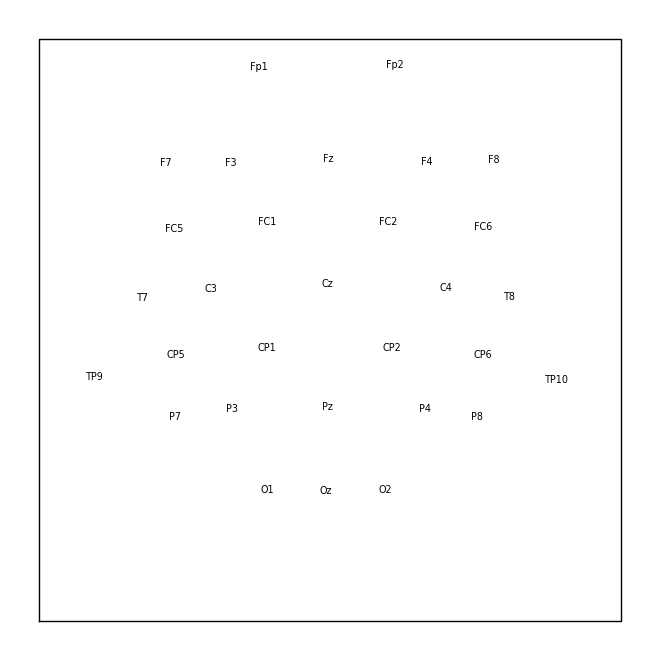

In [5]:
#plotting layout 
layout_from_raw = mne.channels.make_eeg_layout(raw.info)
layout_from_raw.plot();

In [6]:
chans = mne.pick_types(raw.info, meg=False, eeg=True, eog=True)
chan_types = [mne.io.pick.channel_type(raw.info, ch) for ch in chans]
chan_names = raw.info['ch_names']
print('Channels are of type')
print(*('{}: {}'.format(ch, typ) for ch, typ in zip(chan_names, chan_types)), sep='\n')

Channels are of type
Fp1: eeg
Fp2: eeg
F7: eeg
F3: eeg
Fz: eeg
F4: eeg
F8: eeg
FC5: eeg
FC1: eeg
FC2: eeg
FC6: eeg
T7: eeg
C3: eeg
Cz: eeg
C4: eeg
T8: eeg
TP9: eeg
CP5: eeg
CP1: eeg
CP2: eeg
CP6: eeg
TP10: eeg
P7: eeg
P3: eeg
Pz: eeg
P4: eeg
P8: eeg
HEOG: eog
O1: eeg
Oz: eeg
O2: eeg
VEOG: eog


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


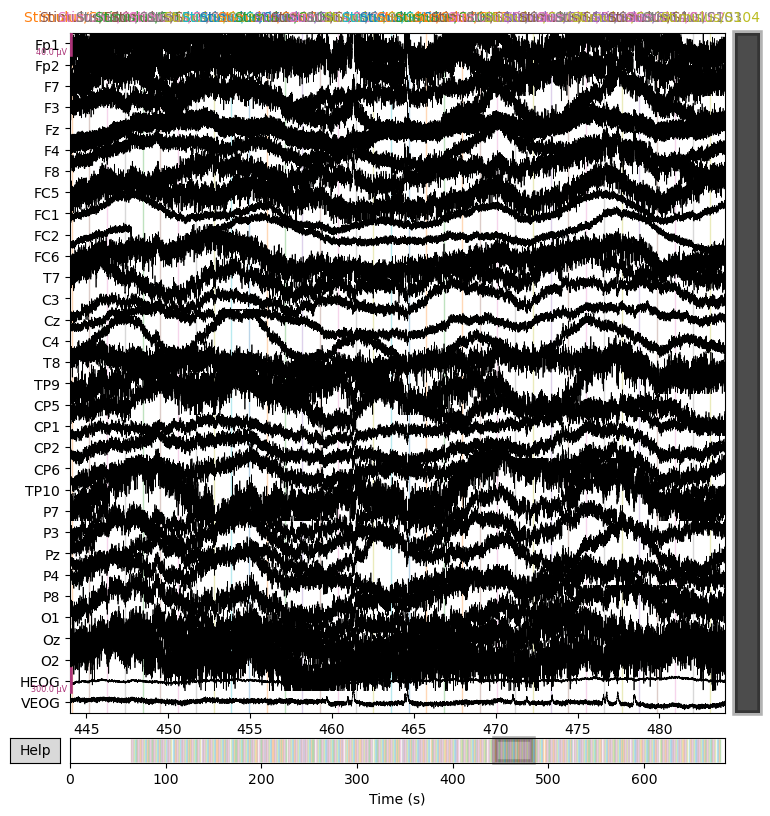

In [7]:
raw.pick_types(meg=False, eeg=True, eog= True, stim=True, exclude=[])
raw.plot(n_channels=32, duration=40, start = 444);

In [8]:
#raw.pick_types(meg=False, eeg=True, eog= True, stim=True, exclude=[])
#raw.plot(scalings=dict(eeg = 20e-5), n_channels=32, duration=40, start = 444);

### Exclude bad channels

The plot of all channels simoustaneously show no bad channels, therefore non of them will be excluded from further analysis

### Common average reference

The idea behind average reference is to compute the average of the signal at all EEG electrodes and subtract it from the EEG signal at every electrode for every time point. To set this “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'. This is done after excluding bad channels, so the average is computed only over the good channels.

The rationale behind this is that the average of all the potentials recorded on the whole head due to current sources inside it is zero, this would make for a quiet or electrically neutral reference. However, in practice, to achieve such an ideal reference one would require large number of electrodes that cover the whole head uniformly, which is not the case in EEG recordings where limited number of electrodes cover mostly the upper part of the head.

If you want to know more, this is a good resource.

In [9]:
raw.set_eeg_reference(ref_channels='average', ch_type='eeg')

Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | own_group9.eeg, 32 x 684820 (684.8 s), ~167.2 MB, data loaded>

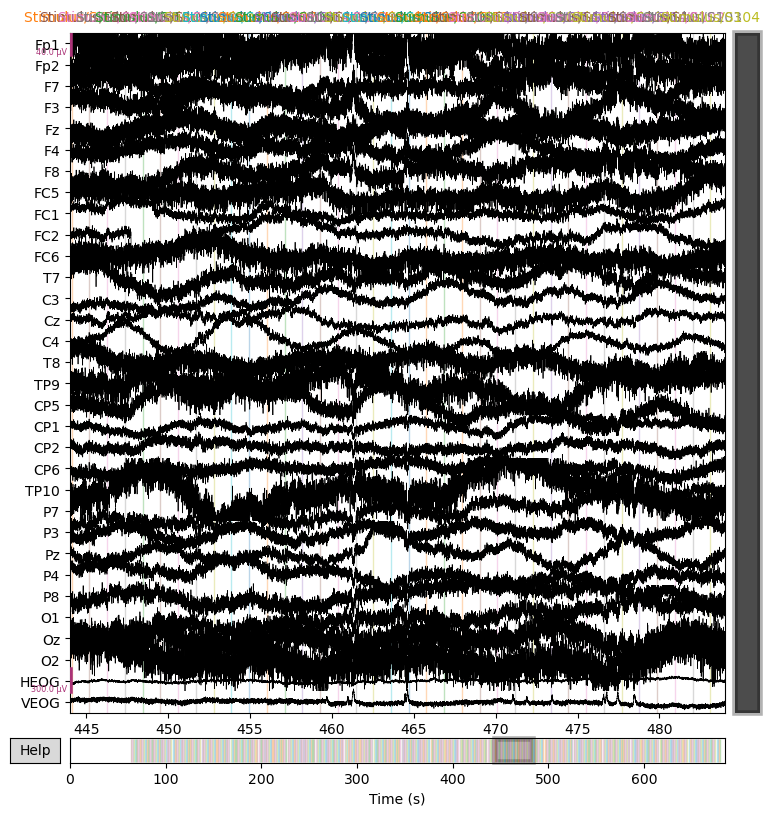

In [10]:
#plotting the data after using the average as a reference 
raw.plot(n_channels=32, duration=40, start=444);

### Filtering

Here i'm applying a high-pass filter at 1 Hz, and a low pass filter at 40 Hz(typical practises of EEG preprocessing

the reason the high-pass filter it 1Hz and not 0.1 Hz is because ICA is very sensitive to slow drifters 

In [11]:
#raw_fit is used for the ICA application
raw_fit = raw.copy().filter(1, None)
#raw_fit = raw.filter(None, 40)

#high and low pass filter for data not used to fit the ICA
raw = raw.filter(0.1, None)
#raw= raw.filter(None, 40)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 s)



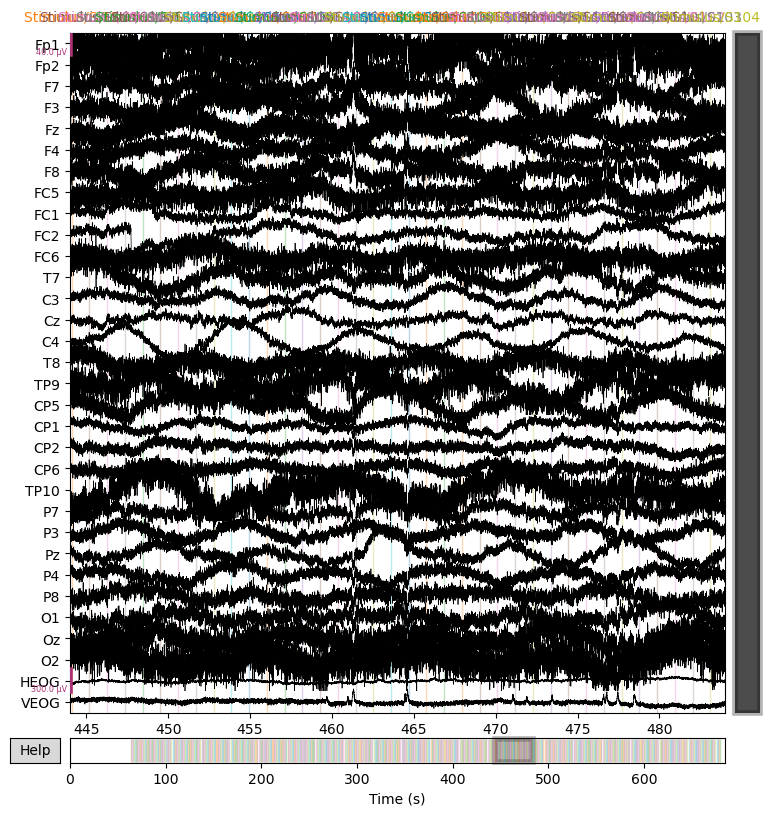

In [12]:
raw.plot(n_channels=32, duration=40, start=444);

### Artefact rejection (using ICA)

ICA (independent component analysis) is used for artefact detection by identifying seperate components of the signal that have been combined during the recording. We seperate noise components like eye blinks, and can thereby exclude them 

In [13]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 37.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 7.0 MB/s eta 0:00:0000:01


In [14]:
import sklearn #scikit-learn

**Set up and fit ICA with mne.preprocessing.ICA() with 800 iterations with a random seed at 7 (for reproducibility) and n_components=0.95**

n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data

In [15]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=7, max_iter=800)
ica.fit(raw_fit)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 15 components
Fitting ICA took 9.4s.


<ICA | raw data decomposition, method: fastica (fit in 15 iterations on 684820 samples), 15 ICA components (30 PCA components available), channel types: eeg, no sources marked for exclusion>

**plotting the ICA components**

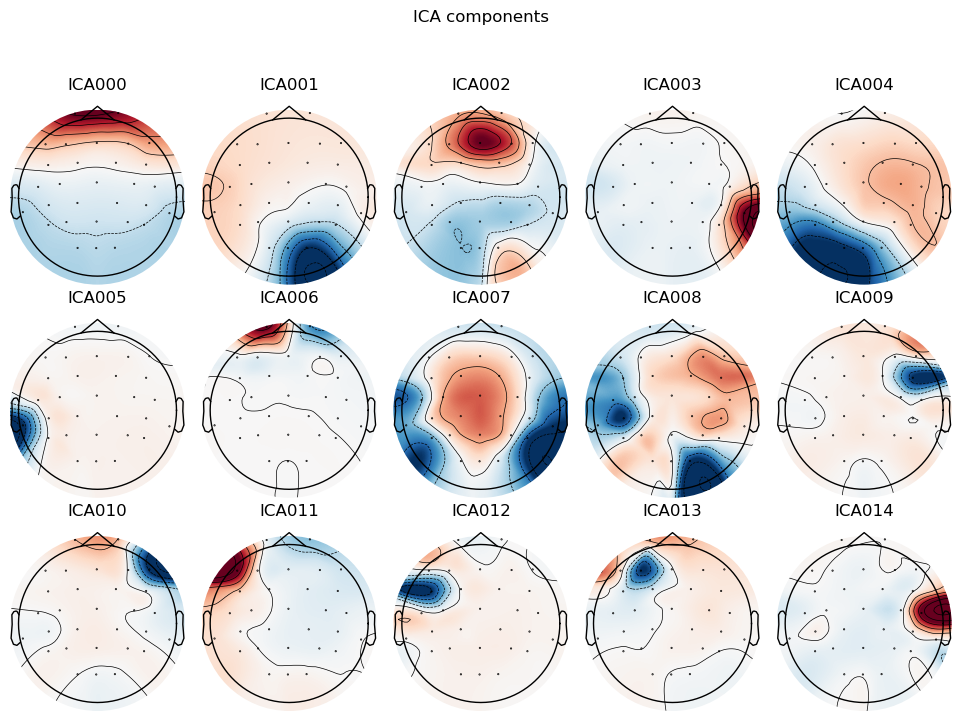

In [16]:
ica.plot_components();

**plotting the time course of the ICA components** 

Creating RawArray with float64 data, n_channels=17, n_times=684820
    Range : 0 ... 684819 =      0.000 ...   684.819 secs
Ready.


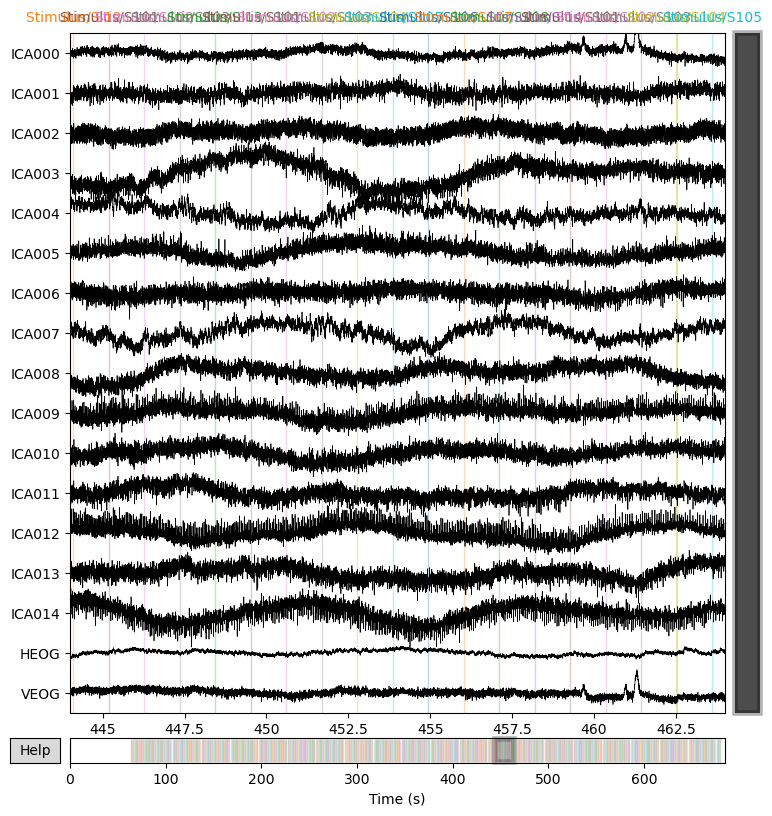

In [17]:
ica.plot_sources(raw, start=444);

**Identifying the noisy components**

component 0 is execluded as it is saccades, no other components is excluded 

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
342 matching events found
No baseline correction applied
0 projection items activated


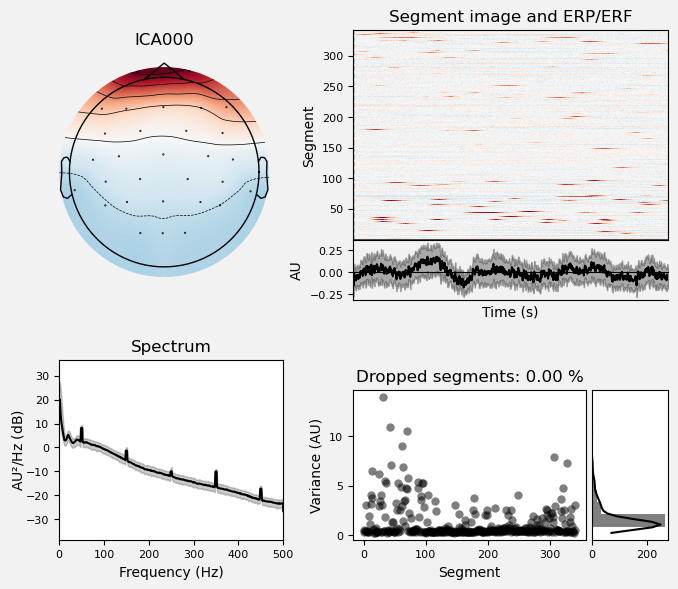

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


<RawBrainVision | own_group9.eeg, 32 x 684820 (684.8 s), ~167.2 MB, data loaded>

In [18]:
ica.exclude=[0]
ica.plot_properties(raw, picks=ica.exclude);

ica.apply(raw)

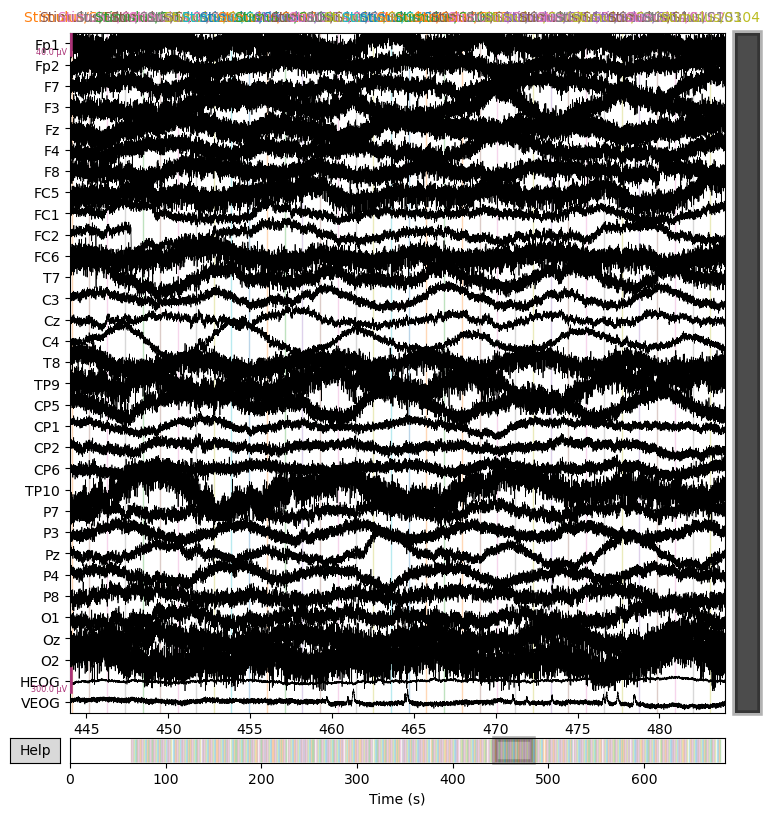

In [19]:
raw.plot(n_channels=32, duration=40, start=444);

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.0s finished


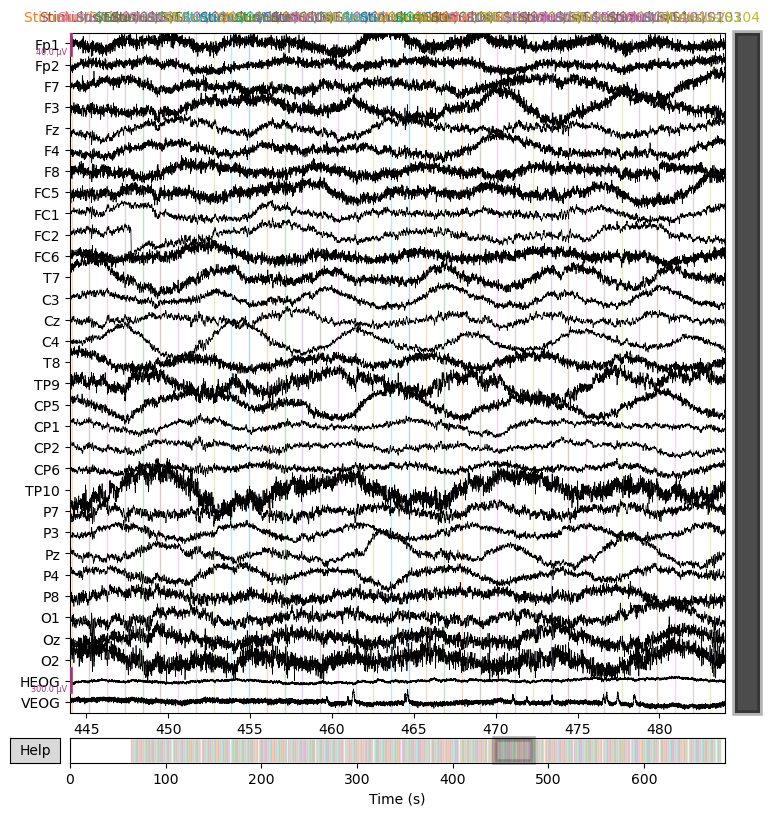

In [20]:
#applying the low-pass filter
raw=raw.filter(None, 40)
raw.plot(n_channels=32, duration=40, start=444);

**seeting reject threshold of 150 microvolts

In [21]:
reject = {'eeg': 150e-6}

###Epoching of EEG data

In [22]:
#locating stimulus events 
events, _=mne.events_from_annotations(raw, verbose=False)
np.unique(events[:,2])

array([   12,    13,    14,   101,   102,   103,   104,   105,   106,
         107,   108, 99999])

In [23]:
import numpy as np

def add_trigger(trigger_list, trigger_code, sample):
    """
    Adds a trigger to the EEG data
    args:
        trigger_list(np.array): The current trigger list
        trigger_code(int): The trigger code for the new trigger
        sample(int): The sample number for the new trigger event
    """
    new_trigger_list = np.append(trigger_list, [[sample, 0, trigger_code]])

    return new_trigger_list.reshape(-1, 3)

In [24]:
#moving triggers 0.5 seconds forward (as this is where the event happen)
# They are giving a new number to not override the existing events

for event in events: # looping over the original
    sample = int(float(event[0]) + 1000 * 0.5)
    if event[2] == 12:
        trigger_code = 112
        events = add_trigger(events, trigger_code, sample)

    elif event[2] == 13:
        trigger_code = 113
        events = add_trigger(events, trigger_code, sample)

    elif event[2] == 14:
        trigger_code = 114
        events = add_trigger(events, trigger_code, sample)
    
    elif event[2] == 101:
        trigger_code = 201
        events = add_trigger(events, trigger_code, sample)
    
    elif event[2] == 102:
        trigger_code = 202
        events = add_trigger(events, trigger_code, sample)

    elif event[2] == 103:
        trigger_code = 203
        events = add_trigger(events, trigger_code, sample)
    
    elif event[2] == 104:
        trigger_code = 204
        events = add_trigger(events, trigger_code, sample)
    
    elif event[2] == 105:
        trigger_code = 205
        events = add_trigger(events, trigger_code, sample)

    elif event[2] == 106:
        trigger_code = 206
        events = add_trigger(events, trigger_code, sample)
    
    elif event[2] == 107:
        trigger_code = 207
        events = add_trigger(events, trigger_code, sample)
       
    elif event[2] == 108:
        trigger_code = 208
        events = add_trigger(events, trigger_code, sample)


print(events)
np.unique(events[:,2])

[[     0      0  99999]
 [ 63626      0    101]
 [ 64343      0    102]
 ...
 [677527      0    206]
 [678611      0    207]
 [679694      0    113]]


array([   12,    13,    14,   101,   102,   103,   104,   105,   106,
         107,   108,   112,   113,   114,   201,   202,   203,   204,
         205,   206,   207,   208, 99999])

/tmp/ipykernel_385/1056365024.py:15: RuntimeWarning: event 12 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
/tmp/ipykernel_385/1056365024.py:15: RuntimeWarning: event 13 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
/tmp/ipykernel_385/1056365024.py:15: RuntimeWarning: event 14 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
/tmp/ipykernel_385/1056365024.py:15: RuntimeWarning: event 101 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
/tmp/ipykernel_385/1056365024.py:15: RuntimeWarning: event 102 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
/tmp/ipykernel_385/1056365024.py:15: RuntimeWarning: event

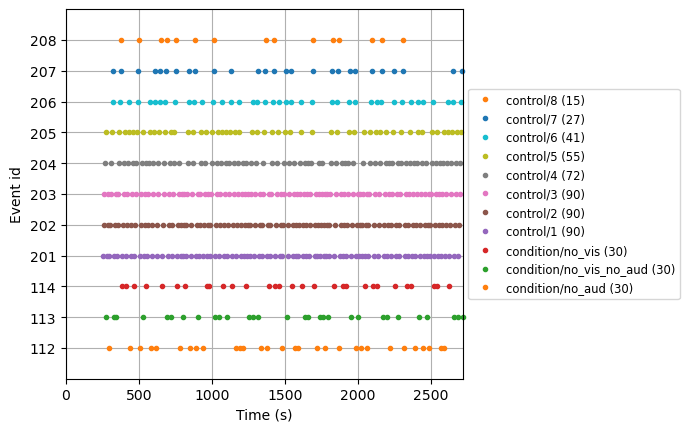

In [25]:
#Making dictionary of what the event ID,s represent
event_id ={'control/1':201,
           'control/2':202,
           'control/3':203,
           'control/4':204,
           'control/5':205,
           'control/6':206,
           'control/7':207,
           'control/8':208,
           'condition/no_aud':112,
           'condition/no_vis_no_aud':113,
           'condition/no_vis':114}

#plotting events 
mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);

**Establishing a timewindow for the epochs**

Using a timewoindow from 200ms before to 500ms after the stimulus onset
This makes it possible to examine the baseline of activity (when there is no stimulus) as well as the timepoints we expect an effect

In [26]:
tmin, tmax = -0.1, 0.5

In [27]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)

In [28]:
# making the epochs 
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0), reject = reject, preload = True)

#Resample the data to 250Hz
epochs_resampled = epochs.resample(250)

Not setting metadata
570 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 570 events and 601 original time points ...
0 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


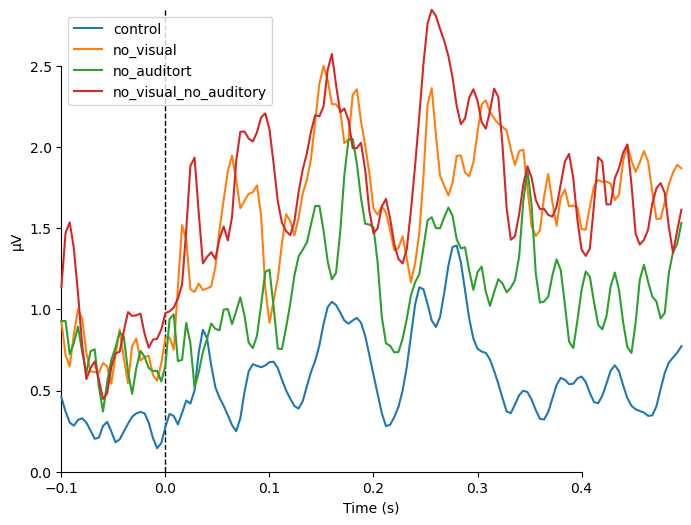

[<Figure size 800x600 with 1 Axes>]

In [29]:
epochs_control = epochs_resampled['control']
epochs_no_vis = epochs_resampled['no_vis']
epochs_no_aud = epochs_resampled['no_aud']
epochs_no_vis_no_aud = epochs_resampled['no_vis_no_aud']

evoked_control = epochs_control.average()
evoked_no_vis = epochs_no_vis.average()
evoked_no_aud = epochs_no_aud.average()
evoked_no_vis_no_aud = epochs_no_vis_no_aud.average()

mne.viz.plot_compare_evokeds(dict(control=evoked_control, no_visual=evoked_no_vis, no_auditort=evoked_no_aud, no_visual_no_auditory=evoked_no_vis_no_aud),
                            legend='upper left', show_sensors='')

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


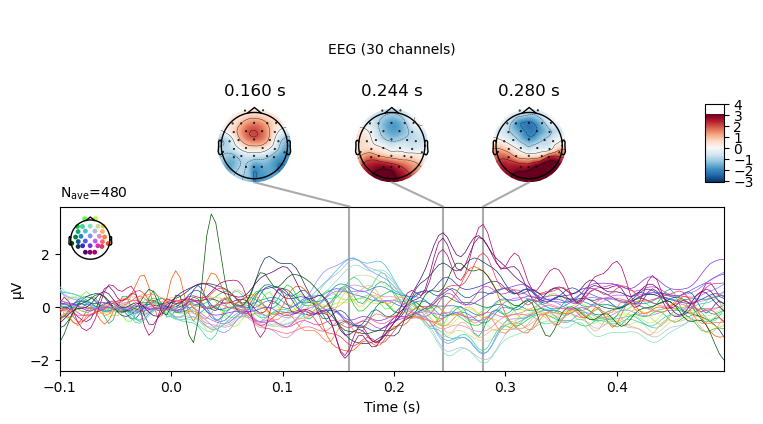

In [30]:
evoked_control.plot_joint(picks='eeg');

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


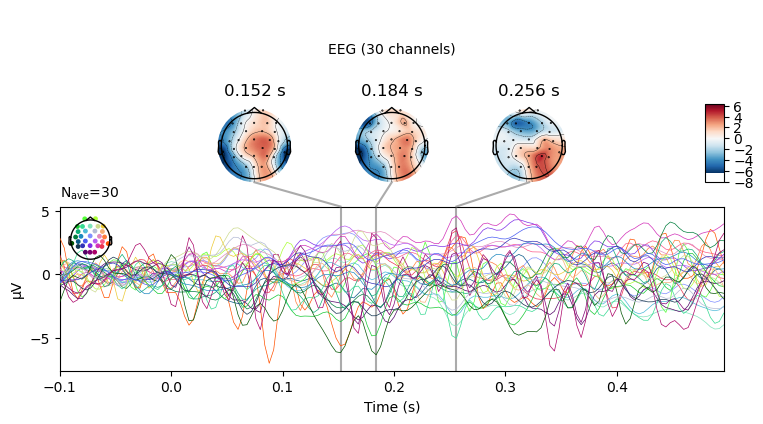

In [31]:
evoked_no_vis.plot_joint(picks='eeg');

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


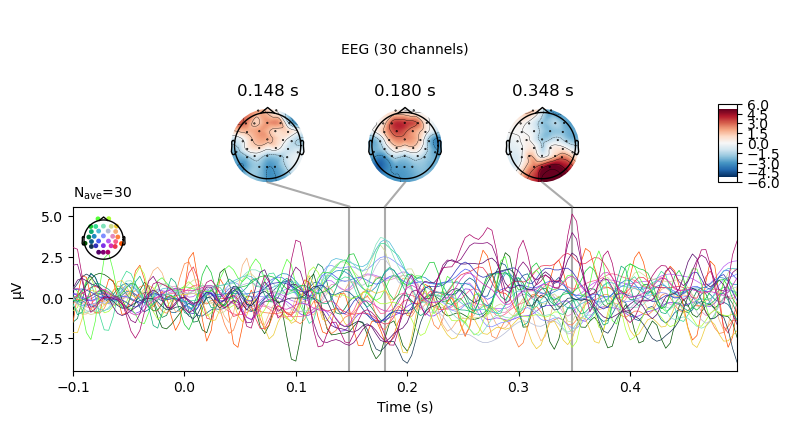

In [32]:
evoked_no_aud.plot_joint(picks='eeg');

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


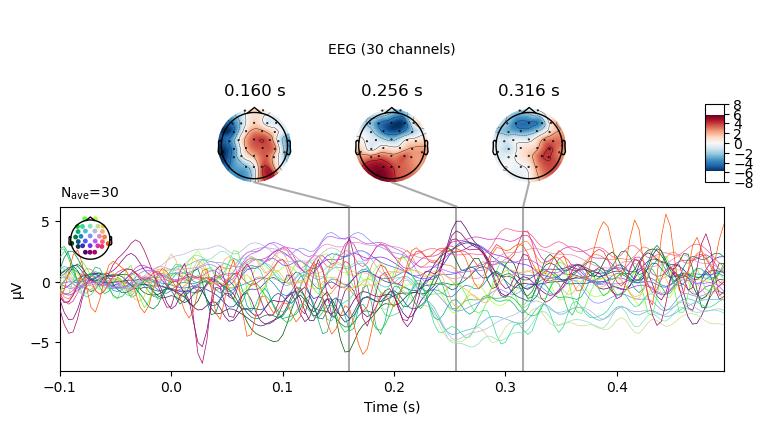

In [33]:
evoked_no_vis_no_aud.plot_joint(picks='eeg');

In [34]:
# saving epochs 
epochs_resampled.save('cogneu_exam_final1_epochs-epo.fif')

**picking out channels**
For future analysis channels were we expect to see an effect needs to be picked out.

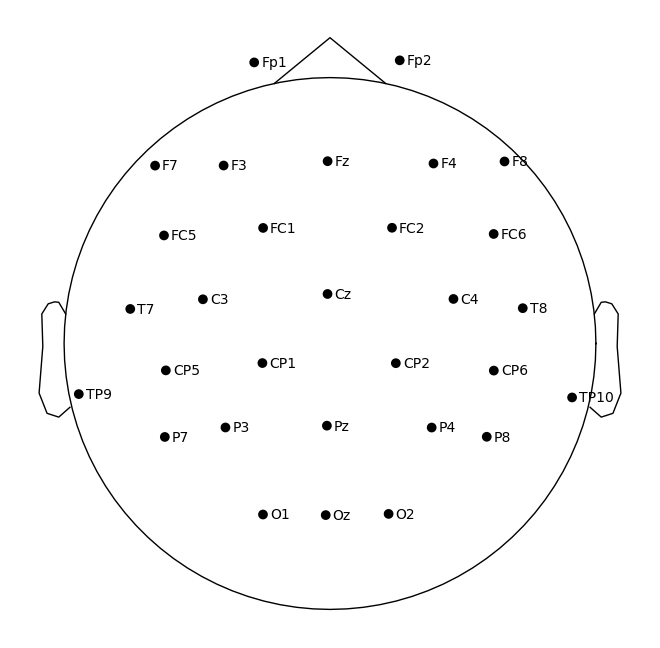

In [35]:
epochs_control.plot_sensors(ch_type='eeg', show_names=True);

It is expected to see an effect in **O1**, **Oz** and **O2** as these channels are above the visual cortex

Further we would expect an effect in ***Fz* (Auditory cortex)

Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated


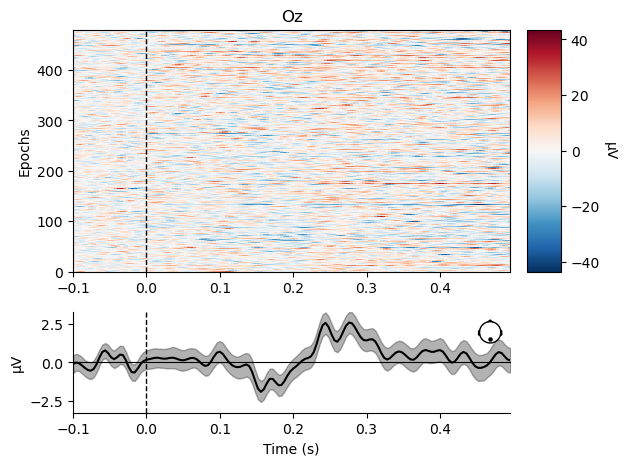

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


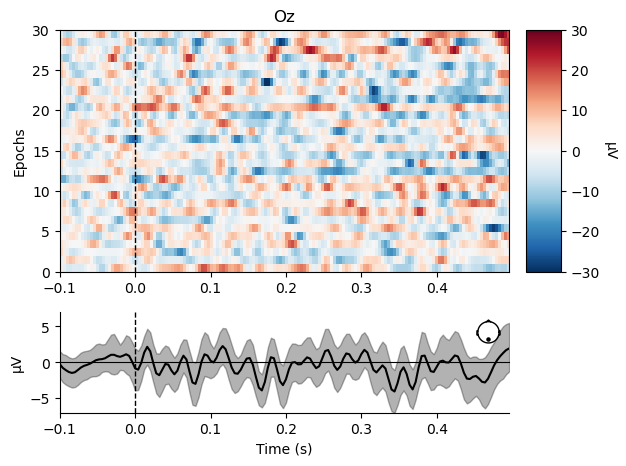

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


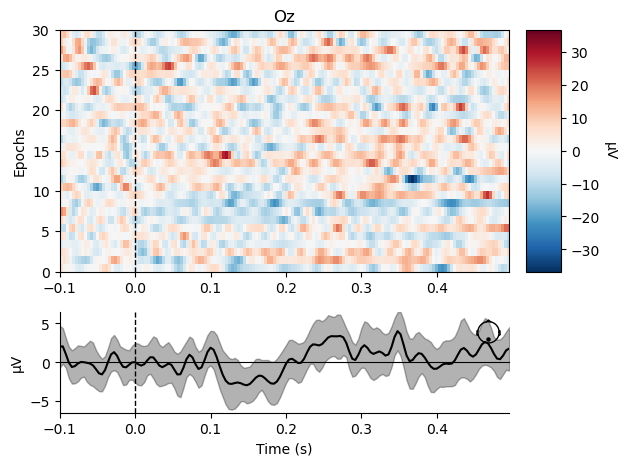

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


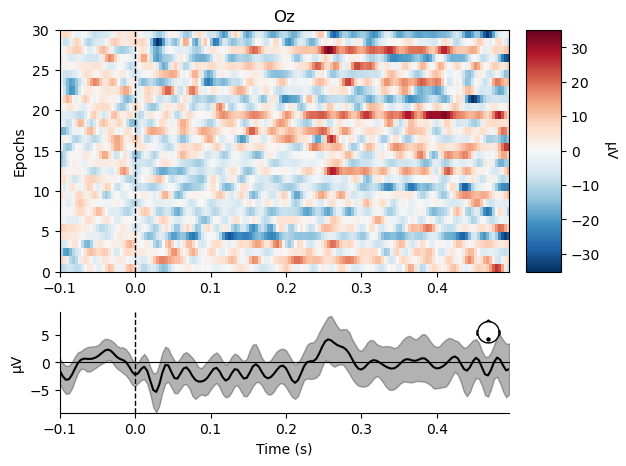

In [36]:
# Oz
epochs_control.plot_image(picks=['Oz']);
epochs_no_vis.plot_image(picks=['Oz']);
epochs_no_aud.plot_image(picks=['Oz']);
epochs_no_vis_no_aud.plot_image(picks=['Oz']);

Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated


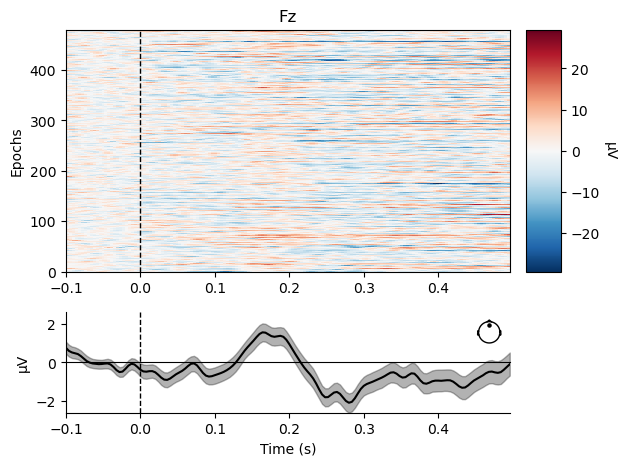

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


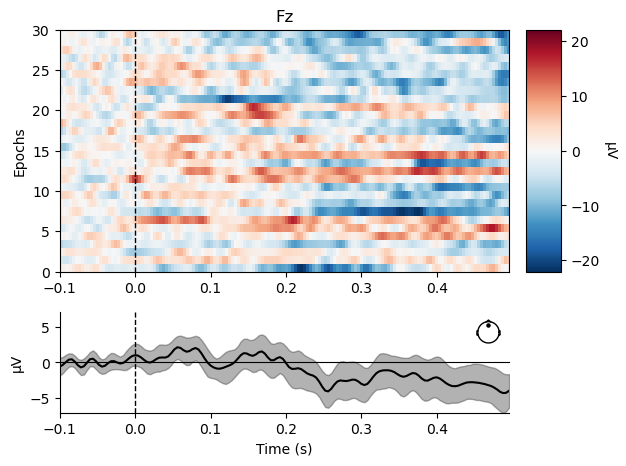

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


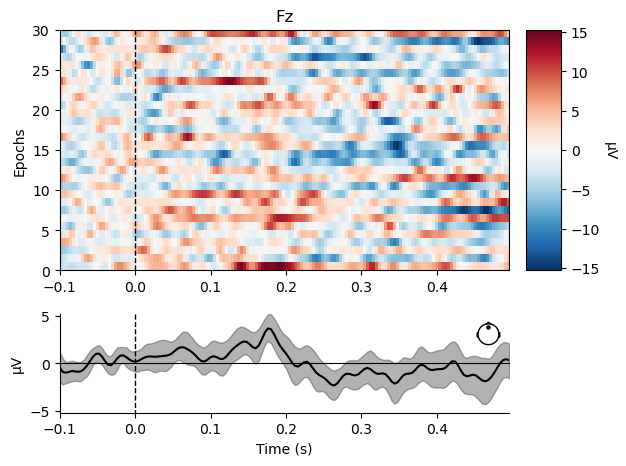

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


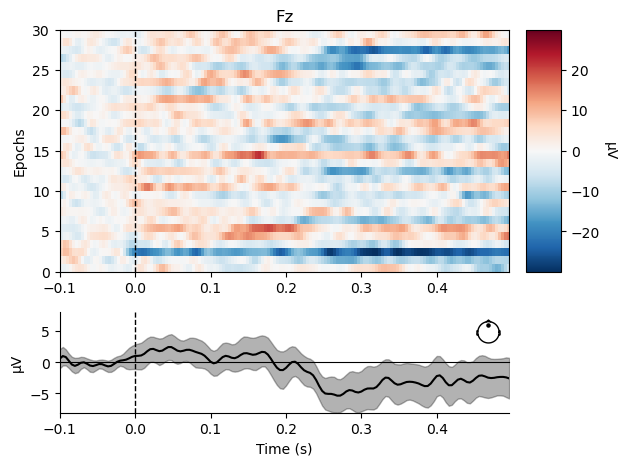

In [37]:
# TP9
epochs_control.plot_image(picks=['Fz']);
epochs_no_vis.plot_image(picks=['Fz']);
epochs_no_aud.plot_image(picks=['Fz']);
epochs_no_vis_no_aud.plot_image(picks=['Fz']);

FileNotFoundError: [Errno 2] No such file or directory: '/Cog_neuro_exam/cogneuro_preprocessing_exam_data.ipynb'